In [3]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image,display

def calculate_bmi(weight_kg: float, height_m: float, age: int, gender: str) -> str:
    """
    Calculates the BMI and returns the BMI category along with insights based on age & gender.
    """
    bmi = weight_kg / (height_m ** 2)
    
    if bmi < 18.5:
        category = "Underweight"
    elif 18.5 <= bmi < 24.9:
        category = "Normal weight"
    elif 25 <= bmi < 29.9:
        category = "Overweight"
    else:
        category = "Obese"

    insight = ""
    if age < 18:
        insight = "For children/teens, use BMI percentiles instead of fixed ranges."
    elif age >= 65:
        insight = "For older adults, BMI may not reflect body fat accurately due to muscle loss."
    
    if gender.lower() == "female" and bmi > 24.9:
        insight += " Women naturally have a higher body fat percentage, so BMI alone may not be the best measure."
    
    return f"BMI: {round(bmi, 2)}, Category: {category}. {insight}"

# Define Diet Plan Tool

def generate_diet_plan(bmi_category: str, dietary_preference: str = "balanced") -> str:
    """
    Generates a diet plan based on BMI category and dietary preference.
    """
    diet_plans = {
        "Underweight": {
            "breakfast": "Oatmeal with nuts & banana + Whole milk",
            "lunch": "Grilled chicken/fish with rice & vegetables",
            "snack": "Protein smoothie with nuts & peanut butter",
            "dinner": "Eggs, avocado toast & fruit juice"
        },
        "Normal weight": {
            "breakfast": "Scrambled eggs with whole-grain toast & fruit",
            "lunch": "Grilled salmon with quinoa & greens",
            "snack": "Greek yogurt with honey & berries",
            "dinner": "Chicken stir-fry with vegetables & brown rice"
        },
        "Overweight": {
            "breakfast": "Boiled eggs with whole wheat toast & green tea",
            "lunch": "Grilled chicken with salad & olive oil dressing",
            "snack": "Nuts & seeds mix or hummus with veggies",
            "dinner": "Grilled fish with steamed vegetables"
        },
        "Obese": {
            "breakfast": "Omelette with spinach & black coffee",
            "lunch": "Grilled lean protein (chicken/fish) with steamed broccoli",
            "snack": "Almonds & walnuts",
            "dinner": "Soup with mixed greens & grilled protein"
        }
    }

    meal_plan = diet_plans.get(bmi_category, "No specific plan available")

    # Modify based on dietary preference
    if dietary_preference == "vegetarian":
        for meal in meal_plan:
            meal_plan[meal] = meal_plan[meal].replace("chicken", "paneer").replace("fish", "tofu").replace("eggs", "chickpeas")
    elif dietary_preference == "high_protein":
        for meal in meal_plan:
            meal_plan[meal] += " + Extra protein source (Whey protein, Lentils, Beans)"
    elif dietary_preference == "keto":
        for meal in meal_plan:
            meal_plan[meal] = meal_plan[meal].replace("rice", "cauliflower rice").replace("quinoa", "zucchini noodles").replace("fruit", "avocado")

    return f"Here is your meal plan based on {bmi_category}: {meal_plan}"

# Define Financial Expense Calculation Tool
def calculate_fitness_expenses(diet_type: str, gym_membership: bool) -> str:
    """
    Estimates the monthly expense based on diet and fitness choices.
    """
    cost_estimates = {
        "balanced": 5000,
        "vegetarian": 4500,
        "high_protein": 6000,
        "keto": 7000
    }
    
    gym_cost = 2000 if gym_membership else 0
    total_cost = cost_estimates.get(diet_type, 5000) + gym_cost
    
    return f"Estimated monthly expense for a {diet_type} diet with {'a gym membership' if gym_membership else 'no gym membership'}: ₹{total_cost}"

# Create the LangChain Agent with the tools
tools = [calculate_bmi, generate_diet_plan, calculate_fitness_expenses]

llm=ChatOpenAI(model='gpt-4o')

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)


class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


from langchain_core.messages import HumanMessage,SystemMessage

##System Message
sys_msg=SystemMessage(content="You are a helpful assistant tasked with health and financial guidance.")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder=StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the edges
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools","assistant")

react_graph=builder.compile()   

messages=[HumanMessage(content="I am 30 years old, male, 75 kg, and 1.75 meters tall. Calculate my BMI and suggest a diet plan for weight loss with expenses.")]
messages=react_graph.invoke({"messages":messages})

print(messages['messages'])

[HumanMessage(content='I am 30 years old, male, 75 kg, and 1.75 meters tall. Calculate my BMI and suggest a diet plan for weight loss with expenses.', additional_kwargs={}, response_metadata={}, id='189462fc-bb50-4360-96c2-4d923ed4e86c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_K2ndmiV8KueZjd6VwKVDxNll', 'function': {'arguments': '{"weight_kg":75,"height_m":1.75,"age":30,"gender":"male"}', 'name': 'calculate_bmi'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 196, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e32ee8e5-e05b-4006-88c6-d16c0d45bf92-0', tool_calls=[{'name': 'calculat

In [4]:
for m in messages['messages']:
    print(m)

content='I am 30 years old, male, 75 kg, and 1.75 meters tall. Calculate my BMI and suggest a diet plan for weight loss with expenses.' additional_kwargs={} response_metadata={} id='189462fc-bb50-4360-96c2-4d923ed4e86c'
content='' additional_kwargs={'tool_calls': [{'id': 'call_K2ndmiV8KueZjd6VwKVDxNll', 'function': {'arguments': '{"weight_kg":75,"height_m":1.75,"age":30,"gender":"male"}', 'name': 'calculate_bmi'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 196, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6dd05565ef', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-e32ee8e5-e05b-4006-88c6-d16c0d45bf92-0' tool_calls=[{'name': 'calculate_bmi', 'args': {'weight_kg': 75,

In [5]:
print(messages['messages'][0].content)

I am 30 years old, male, 75 kg, and 1.75 meters tall. Calculate my BMI and suggest a diet plan for weight loss with expenses.


In [6]:
print(messages['messages'][-1].content)

Based on your BMI of 24.49, you fall into the "Normal weight" category. Here's a suggested diet plan for weight loss:

- **Breakfast**: Scrambled eggs with whole-grain toast & fruit
- **Lunch**: Grilled salmon with quinoa & greens
- **Snack**: Greek yogurt with honey & berries
- **Dinner**: Chicken stir-fry with vegetables & brown rice

To support your weight loss goals, including a gym membership along with your dietary plan, the estimated monthly expense would be approximately ₹7000. This includes costs for both the diet and gym.


In [7]:
for m in messages['messages']:
    if m.name is not None:
        print(f"Tool Call: {m.name}() \n{m.content} \n=================================================\n")

print(messages['messages'][-1].content)

Tool Call: calculate_bmi() 
BMI: 24.49, Category: Normal weight.  

Tool Call: generate_diet_plan() 
Here is your meal plan based on Normal weight: {'breakfast': 'Scrambled eggs with whole-grain toast & fruit', 'lunch': 'Grilled salmon with quinoa & greens', 'snack': 'Greek yogurt with honey & berries', 'dinner': 'Chicken stir-fry with vegetables & brown rice'} 

Tool Call: calculate_fitness_expenses() 
Estimated monthly expense for a weight loss diet with a gym membership: ₹7000 

Based on your BMI of 24.49, you fall into the "Normal weight" category. Here's a suggested diet plan for weight loss:

- **Breakfast**: Scrambled eggs with whole-grain toast & fruit
- **Lunch**: Grilled salmon with quinoa & greens
- **Snack**: Greek yogurt with honey & berries
- **Dinner**: Chicken stir-fry with vegetables & brown rice

To support your weight loss goals, including a gym membership along with your dietary plan, the estimated monthly expense would be approximately ₹7000. This includes costs fo

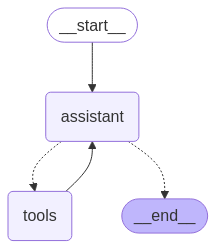

In [8]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))